In [1]:
import numpy as np
import matplotlib.pyplot as plt

from funicular import *

# Vault Form Finding

The goal of this notebook is to create an algorithm that can create a funicular form for any given sequence of loads and desired geometric constraints. 

The geometric constraints are bounded by points X, Y, Z: 
<br>X = starting point of the vault (typically (0, 0))
<br>Y = any point along the length of the vault
<br>Z = ending point of the vault

# Helper Functions Necessary

In [2]:
'''
GET Y VALUE ON A FORM AT A GIVEN X

poly = funicular polygon object
x = x location
'''
def get_Y(poly, x):
    i = np.where(poly.X<=x)[0][-1]
    mi = (poly.Y[i+1]-poly.Y[i])/(poly.X[i+1]-poly.X[i])
    y = mi * (x-poly.X[i]) + poly.Y[i]
    return y  


'''
INTERSECTION OF 2 LINES

m = array of slopes [m1, m2]
x0 = x coordinate of points [x1, x2]
y0 = y coordinates of points [y1, y2]
'''
def get_intersect(m, x0, y0):
    
    b=[]
    for i in range(len(m)):
        b.append(m[i]*-x0[i] + y0[i])
    
    B = np.array(b).reshape(2, 1)
    A = np.array([[-m[0], 1], [-m[1], 1]])
    X = la.solve(A, B)
    
    return (X[0][0], X[1][0])


'''
FIND INTERSECTION OF A LINE WITH THE LOAD LINE

poly = funicular polygon object
p = point in force space 
m = slope of line
'''
def load_line_intersect(poly, p, m):
    Y= m*(poly.load_line[:, 0] - p[0]) + p[1]

    i1 = np.where(Y>=poly.load_line[:, 1])[0][0]
    i0 = i1-1

    p0 = poly.load_line[i0]
    p1 = poly.load_line[i1]

    if p0[0] == p1[0]: inter = (p0[0], Y[i0])
    else:
        mLL = (p1[1]-p0[1])/(p1[0]-p0[0])
        xL = poly.load_line[i0, 0]
        yL = poly.load_line[i0, 1]
        inter = get_intersect([m, mLL], [p[0], xL], [p[1], yL])
        
    return inter


'''
FIND FORM OF VAULT GIVEN 3 POINTS
'''
def find_form(poly, X_loc, X, Y, Z):
    
    # Slopes to build vault
    XY = (Y[1]-X[1])/(Y[0]-X[0])
    ZY = (Y[1]-Z[1])/(Y[0]-Z[0])
    
    poly.origin = (np.min(poly.load_line[:, 0])-2, poly.load_line[-1, 1]/2)
    poly.get_geometry(X_loc, start=X[1])
    
    zdiff = 1
    iters = 0
    while zdiff >= .01 and iters<100:
        
        # Plot where Y falls onto this form
        y = (Y[0], get_Y(poly, Y[0]))

        # Get this origin's slopes to y
        x = (poly.X[0], poly.Y[0])
        z = (poly.X[-1], poly.Y[-1])

        xy = (y[1]-x[1])/(y[0]-x[0])
        zy = (y[1]-z[1])/(y[0]-z[0])

        # Get intersections with load line
        m = load_line_intersect(poly, poly.origin, xy)
        n = load_line_intersect(poly, poly.origin, zy)

        # Use these points and the desired slopes to find new origin
        O = get_intersect([XY, ZY], [m[0], n[0]], [m[1], n[1]])    

        # Get new funicular polygon
        poly.origin = O
        poly.get_geometry(X_loc, start=X[1])
            
        zdiff = abs(Z[1]-poly.Y[-1])
        iters+=1
        
    
    return O

In [3]:
loads = [[0, -2], [0, -2], [0, -2], [0, -2]]
span = 10

X_loc = (np.cumsum(np.ones((1, len(loads)+2)))-1) *span/(len(loads)+1)

In [4]:
# Geometric points on vault
X = (0, 0)
Y = (5, 10)
Z = (10, 0)

# Slopes to build vault
XY = (Y[1]-X[1])/(Y[0]-X[0])
ZY = (Y[1]-Z[1])/(Y[0]-Z[0])

In [5]:
# Build Funicular Polygon
poly = funicular_polygon()
poly.set_loads(loads)

# First trial
trial_origin = (-2, -6)
poly.origin = trial_origin
poly.get_geometry(X_loc)


# Plot where Y falls onto this form
y = (Y[0], get_Y(poly, Y[0]))

# Get this origin's slopes to y
x = (poly.X[0], poly.Y[0])
z = (poly.X[-1], poly.Y[-1])

xy = (y[1]-x[1])/(y[0]-x[0])
zy = (y[1]-z[1])/(y[0]-z[0])

# Get intersections with load line
m = load_line_intersect(poly, poly.origin, xy)
n = load_line_intersect(poly, poly.origin, zy)

# Use these points and the desired slopes to find new origin
O = get_intersect([XY, ZY], [m[0], n[0]], [m[1], n[1]])

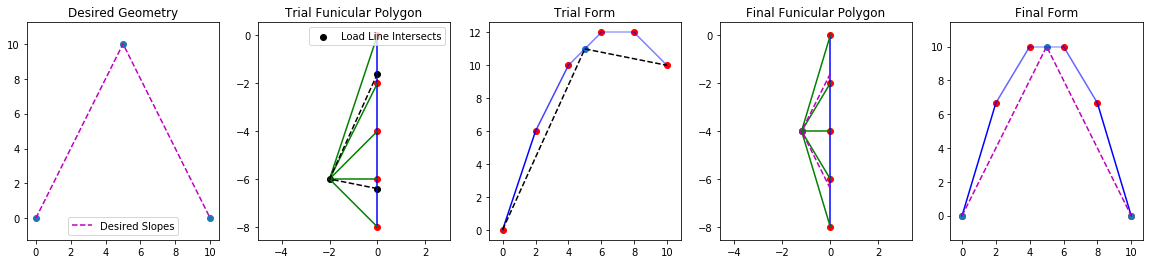

In [6]:
# Plot trial polygon
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
poly.plot_force(ax=ax[1])
poly.plot_form(ax=ax[2])

# Plot Geometry of Form
ax[2].scatter(y[0], y[1])
ax[2].plot([poly.X[0], y[0], poly.X[-1]], [poly.Y[0], y[1], poly.Y[-1]], 'k--')


# Plot load line intersects
fp_plot = ax[1].scatter([m[0], n[0]], [m[1], n[1]], c='k')
ax[1].legend([fp_plot], ['Load Line Intersects'])


# Plot new origin from desired slopes
ax[1].plot([m[0], poly.origin[0]], [m[1], poly.origin[1]], 'k--')
ax[1].plot([n[0], poly.origin[0]], [n[1], poly.origin[1]], 'k--')


# Plot desired geometry
dy = y[1]-Y[1]
ax[0].scatter([X[0], Y[0], Z[0]], [X[1], Y[1], Z[1]])
slopes_plot = ax[0].plot([X[0], Y[0], Z[0]], [X[1], Y[1], Z[1]], 'm--')
ax[0].legend([slopes_plot[0]], ['Desired Slopes'])


# Get new funicular polygon
poly.origin = O
poly.get_geometry(X_loc)


# Plot new funicular form + polygon
poly.plot_force(ax=ax[3])
ax[3].plot([m[0], O[0]], [m[1], O[1]], 'm--')
ax[3].plot([n[0], O[0]], [n[1], O[1]], 'm--')
ax[3].scatter(O[0], O[1], c='m')

poly.plot_form(ax=ax[4])
ax[4].scatter([X[0], Y[0], Z[0]], [X[1], Y[1], Z[1]])
ax[4].plot([X[0], Y[0], Z[0]], [X[1], Y[1], Z[1]], 'm--')


# Title + equalize axes
ax[0].set_title('Desired Geometry')
ax[1].set_title('Trial Funicular Polygon')
ax[2].set_title('Trial Form')
ax[3].set_title('Final Funicular Polygon')
ax[4].set_title('Final Form')
for a in ax:
    a.axis('equal')

# Iterative Function for Form Finding

The above method works in 1 iteration when there are no horizontal or inclined forces introduced. To get a form that fits the geometric constraints, this process becomes iterative until the geometric points are within a desired amount of error. 

To do this, the "find form(X_loc, X, Y, Z)" function was created which repeats the process show above, measuring the error about point Z specifically. In each loop, the trial origin is taken from the previous iteration and the process repeats to find the new origin to fit the constraints. 

In [7]:
loads = [[0, -2], [2, -2], [-1, -2], [-1, -4], [-3, -4]]
span = 10

X_loc = (np.cumsum(np.ones((1, len(loads)+2)))-1) *span/(len(loads)+1)

poly = funicular_polygon()
poly.set_loads(loads)

X = (0, 0)
Y = (5.5, 6)
Z = (10, 0)

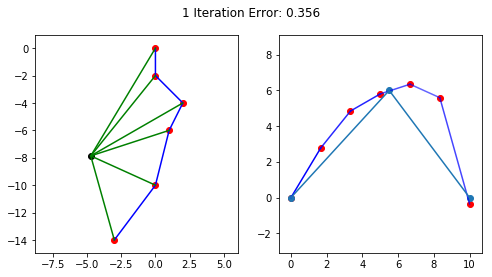

In [8]:
o = poly.find_form(X_loc, X, Y, Z, max_iters=1)

error = (poly.Y[-1] - Z[1])

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

poly.plot_force(ax=ax[0])
poly.plot_form(ax=ax[1])
ax[1].plot([X[0], Y[0], Z[0]], [X[1], Y[1], Z[1]])
ax[1].scatter([X[0], Y[0], Z[0]], [X[1], Y[1], Z[1]])

plt.suptitle('1 Iteration Error: '+str(round(abs(error), 3)))

for a in ax:
    a.axis('equal')

With the irregular load load, one iteration of this process creates a relatively large error and the geometric constraints are not satisfied. To fix this, the process loops and continually refines the origin coordinates until this error is reduced. 

The function created to do this operates with a maximum iteration count of 100 and a desired error of 0.01. These values can be changed as desired. 

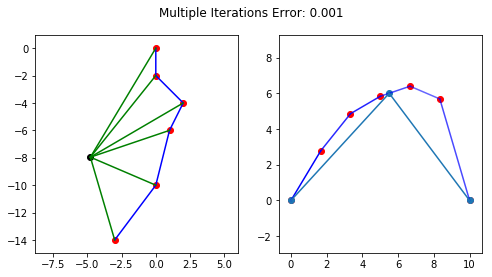

In [9]:
o = poly.find_form(X_loc, X, Y, Z, error=0.001)

error = (poly.Y[-1] - Z[1])

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

poly.plot_force(ax=ax[0])
poly.plot_form(ax=ax[1])
ax[1].plot([X[0], Y[0], Z[0]], [X[1], Y[1], Z[1]])
ax[1].scatter([X[0], Y[0], Z[0]], [X[1], Y[1], Z[1]])

plt.suptitle('Multiple Iterations Error: '+str(round(abs(error), 3)))

for a in ax:
    a.axis('equal')

After iterating through until the error is below 0.01, the geometric form more closely follows the constraints while still being funicular. 